In [9]:
import sys
import os
import numpy as np
from pathlib import Path
import cv2
# Add the path to 'lib' directory
sys.path.append(os.path.abspath(os.path.join('..', 'lib')))

# Now try importing
from calibration.cv2api.calibrate import read_chessboards,calibrate_camera
from calibration.cv2api.detect import detect_pose
from config.ConfigManager import ConfigManager
from calibration.json_utils.json_functions import generate_json_for_images

config_manager = ConfigManager('config.json')

ARUCO_DICT = cv2.aruco.DICT_6X6_250
SQUARES_VERTICALLY = 13
SQUARES_HORIZONTALLY = 9
SQUARE_LENGTH = 0.03
MARKER_LENGTH = 0.02

dictionary = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
board = cv2.aruco.CharucoBoard((SQUARES_VERTICALLY, SQUARES_HORIZONTALLY), SQUARE_LENGTH, MARKER_LENGTH, dictionary)
print("Setup with this board", board.getDictionary())

def calibrate_and_write(project_name,  output_folder):

    image_files = [os.path.join(output_folder, f) for f in os.listdir(output_folder) if f.endswith(".jpg") or f.endswith(".png") or f.endswith(".bmp")]
    image_files.sort()  # Ensure files are in order

    allCorners,allIds,imsize,num_of_detected_markers=read_chessboards(image_files,board)

    print(allCorners)


    ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize,board)
    print(ret,mtx)
    if(ret!=-1):
        np.save(os.path.join(output_folder,"camera_matrix.npy"), mtx)
        np.save(os.path.join(output_folder,"camera_dist_coeff.npy"),dist)
        config_manager.update_project(project_name, {"calibrated": True, "camera_matrix": mtx.tolist(),
                                                "dist_coeff": dist.tolist()})
        return mtx,dist
    else:
        print("no calibration data were found")
        return None, None 



input = "../node-red/projects/calib5/"

output_folder = input
project_name = "test"
mtx = None
dist = None
num_of_images = 40

if(os.path.isdir(input)):
    config_manager.update_project(project_name, {"images": output_folder})
    mtx,dist = calibrate_and_write(project_name, output_folder)
else:
    err = os.system(f"sfextract --frame-count {num_of_images} {input} --output {output_folder}")  
    if(err):
        print("Error occured while generating images from video")
    else:
        config_manager.update_project(project_name, {"images": output_folder})
        mtx,dist = calibrate_and_write("test", output_folder)

if mtx is not None and mtx.any():
    generate_json_for_images(input,os.path.join(input,"transforms_centered.json"),mtx,dist,board,colmap = True)
else:
    print("Cannot do detection, to little charuco markers were found")


Setup with this board < cv2.aruco.Dictionary 0x7facc5052130>
POSE ESTIMATION STARTS:
Using this board  < cv2.aruco.Dictionary 0x7facc5052130>
=> Processing image ../node-red/projects/calib5/Image__2024-11-19__11-47-46.bmp
(1532, 2500)
=> Processing image ../node-red/projects/calib5/Image__2024-11-19__11-47-50.bmp
(1532, 2500)
=> Processing image ../node-red/projects/calib5/Image__2024-11-19__11-47-54.bmp
(1532, 2500)
=> Processing image ../node-red/projects/calib5/Image__2024-11-19__11-47-58.bmp
(1532, 2500)
=> Processing image ../node-red/projects/calib5/Image__2024-11-19__11-48-02.bmp
(1532, 2500)
=> Processing image ../node-red/projects/calib5/Image__2024-11-19__11-48-07.bmp
(1532, 2500)
=> Processing image ../node-red/projects/calib5/Image__2024-11-19__11-48-12.bmp
(1532, 2500)
=> Processing image ../node-red/projects/calib5/Image__2024-11-19__11-48-20.bmp
(1532, 2500)
=> Processing image ../node-red/projects/calib5/Image__2024-11-19__11-48-23.bmp
(1532, 2500)
=> Processing image .

In [13]:
mtx

array([[5.11191172e+03, 0.00000000e+00, 1.19946742e+03],
       [0.00000000e+00, 5.18487588e+03, 8.49791333e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

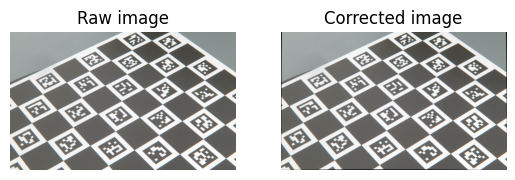

21


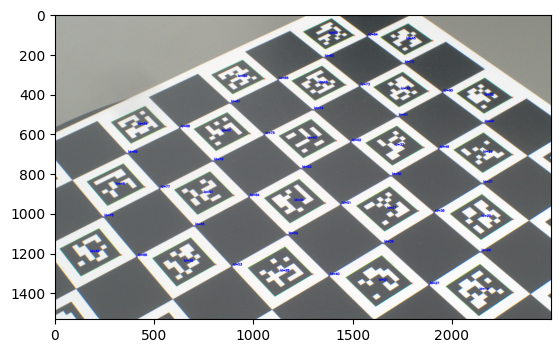

(True, array([[-0.29509793],
       [ 0.99117176],
       [ 2.32544375]]), array([[0.20721507],
       [0.04025625],
       [0.42429225]]))


In [12]:
from matplotlib import pyplot as plt
import cv2


def undistort_image(image, camera_matrix, dist_coeffs):
    h, w = image.shape[:2]
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 1, (w, h))
    undistorted_image = cv2.undistort(image, camera_matrix, dist_coeffs, None, new_camera_matrix)
    return undistorted_image

i=5 # select image id
plt.figure()
frame = cv2.imread(input+"Image__2024-11-19__11-48-23.bmp")
img_undist = undistort_image(frame,mtx,dist)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.show()
print(detect_pose(frame,mtx,dist,board = board,debug_viz = True))


2
Not enough markers detected.
(False, None, None)


In [2]:
from lib.calibration.viz_utils.viz_cameras import camera_with_frustums 

In [4]:
camera_with_frustums("../node-red/projects/benchmark_4x4_phone/transforms_centered.json","../node-red/projects/benchmark_4x4_phone/cameras.html")